In [1]:
!curl -s https://course.fast.ai/setup/colab | bash

Updating fastai...
Done.


In [2]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/"
base_dir = root_dir + 'MamutHackv2/'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
from fastai.vision import *
from fastai.metrics import error_rate
from pathlib import Path
from glob2 import glob
from sklearn.metrics import confusion_matrix

import pandas as pd
import numpy as np
import os
import zipfile as zf
import shutil
import re
import seaborn as sns

# Split data into Train, Validation and test sets


In [0]:
path = Path(base_dir + 'dataset_resized/')
classes = ['brown','cardboard','glass','green_point','metal','paper','plastic']

In [0]:
sizes = [168, 224]

In [6]:
cd gdrive/

/content/gdrive


In [7]:
cd My Drive/

/content/gdrive/My Drive


In [8]:
cd Mamuthackv2/

/content/gdrive/My Drive/Mamuthackv2


In [9]:
ls

data/  dataset_resized/  export_extras.pkl


- Once split, the dataset contains the following subfolders

In [10]:
os.listdir(os.path.join(os.getcwd(),"dataset_resized"))

['cardboard', 'plastic', 'metal', 'brown', 'green_point', 'glass', 'paper']

In [11]:
## get a path to the folder with images
path = Path(os.getcwd())/"data"
path

PosixPath('/content/gdrive/My Drive/Mamuthackv2/data')

In [0]:
def get_data(size):
  tfms = get_transforms(do_flip=True,flip_vert=True, max_rotate=40, max_zoom = 1.3, max_lighting=0.5, max_warp=0.3)
  return ImageDataBunch.from_folder(path,test="test",ds_tfms=tfms,size=size,bs=32).normalize(imagenet_stats)
   

In [0]:
data = get_data(sizes[0])

In [14]:
data

ImageDataBunch;

Train: LabelList (1514 items)
x: ImageList
Image (3, 168, 168),Image (3, 168, 168),Image (3, 168, 168),Image (3, 168, 168),Image (3, 168, 168)
y: CategoryList
paper,paper,paper,paper,paper
Path: /content/gdrive/My Drive/Mamuthackv2/data;

Valid: LabelList (776 items)
x: ImageList
Image (3, 168, 168),Image (3, 168, 168),Image (3, 168, 168),Image (3, 168, 168),Image (3, 168, 168)
y: CategoryList
brown,brown,brown,brown,brown
Path: /content/gdrive/My Drive/Mamuthackv2/data;

Test: LabelList (761 items)
x: ImageList
Image (3, 168, 168),Image (3, 168, 168),Image (3, 168, 168),Image (3, 168, 168),Image (3, 168, 168)
y: EmptyLabelList
,,,,
Path: /content/gdrive/My Drive/Mamuthackv2/data

In [15]:
print(data.classes)

['brown', 'cardboard', 'glass', 'green_point', 'metal', 'paper', 'plastic']


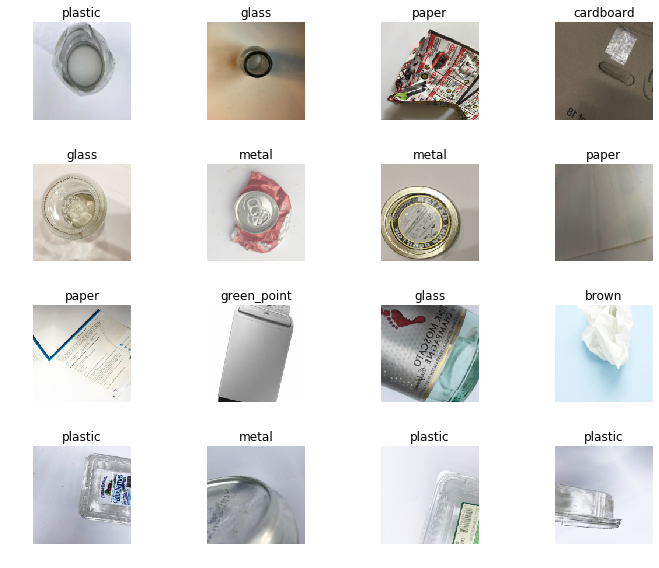

In [16]:
data.show_batch(rows=4,figsize=(10,8))

# Model training

In [17]:
learn = cnn_learner(data,models.resnet34,metrics=accuracy, callback_fns=ShowGraph)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:03<00:00, 24.8MB/s]


In [0]:
learn.model

##  Find learning rate

In [0]:
learn.lr_find(start_lr=1e-6,end_lr=1e1)
learn.recorder.plot()

## Train model

epoch,train_loss,valid_loss,accuracy,time
0,2.444114,1.065788,0.617268,04:08
1,1.595997,0.613551,0.788660,00:32
2,1.141809,0.581110,0.806701,00:32
3,0.930248,0.498645,0.829897,00:32
4,0.804702,0.522807,0.850515,00:32
5,0.725196,0.518795,0.835052,00:32
6,0.629687,0.376693,0.862113,00:33
7,0.536934,0.349760,0.875000,00:34
8,0.490088,0.339267,0.875000,00:34
9,0.432794,0.345901,0.886598,00:34


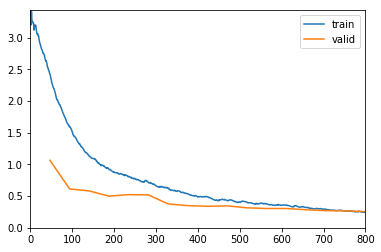

In [18]:
learn.fit_one_cycle(17,max_lr=3e-03)


In [0]:
learn.save('stage-1')

In [0]:
learn.unfreeze()

In [21]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


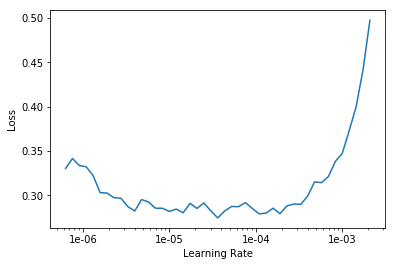

In [24]:
learn.recorder.plot(skip_end=10)

epoch,train_loss,valid_loss,accuracy,time
0,0.247228,0.260940,0.904639,00:35
1,0.257952,0.255870,0.909794,00:34
2,0.263236,0.260466,0.903351,00:34


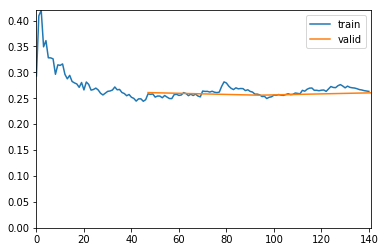

In [25]:
learn.fit_one_cycle(3, max_lr=slice(1e-06,7e-06))

In [0]:
learn.save('stage-2')

In [0]:
learn.load('stage-2');

## Training with another size

In [0]:
data = get_data(sizes[1])

In [32]:
learn.lr_find(start_lr=1e-6,end_lr=1e1)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


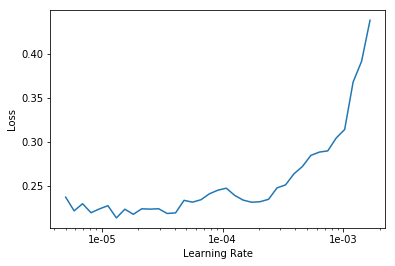

In [33]:
learn.recorder.plot()

epoch,train_loss,valid_loss,accuracy,time
0,0.238643,0.250880,0.904639,00:35
1,0.282096,0.357592,0.889175,00:36
2,0.305625,0.290267,0.886598,00:35
3,0.274877,0.255308,0.905928,00:36
4,0.246969,0.265375,0.911082,00:36
5,0.210393,0.238530,0.921392,00:36
6,0.192016,0.239410,0.929124,00:36


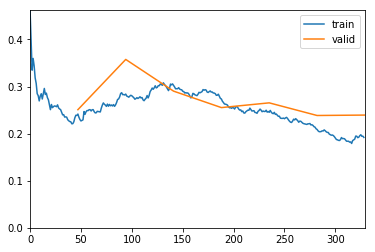

In [36]:
learn.fit_one_cycle(7,max_lr=6e-05)


In [0]:
learn.save('stage-3')

# Visualizing most incorrect images

In [0]:
interp = ClassificationInterpretation.from_learner(learn)
losses,idxs = interp.top_losses()

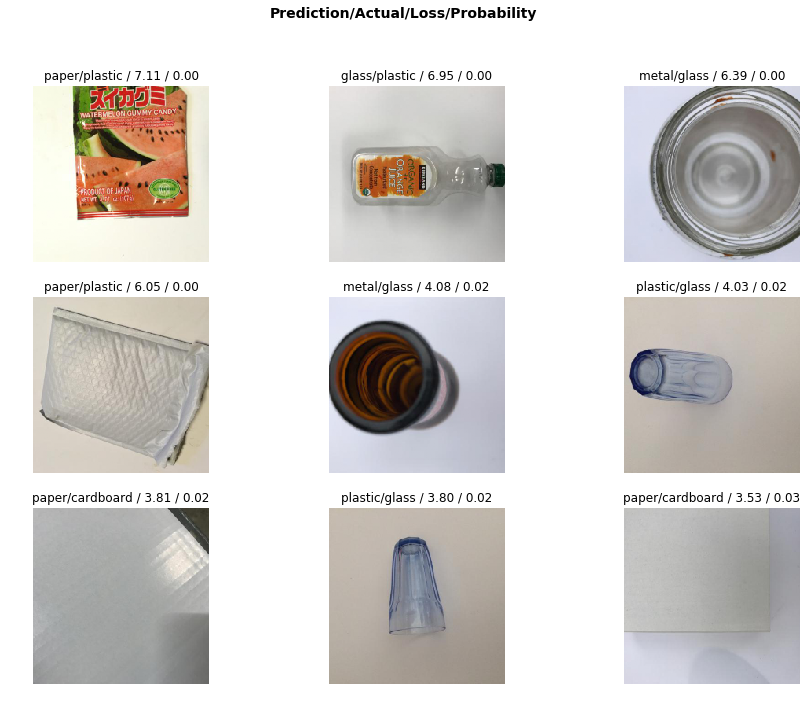

In [0]:
interp.plot_top_losses(9, figsize=(15,11))

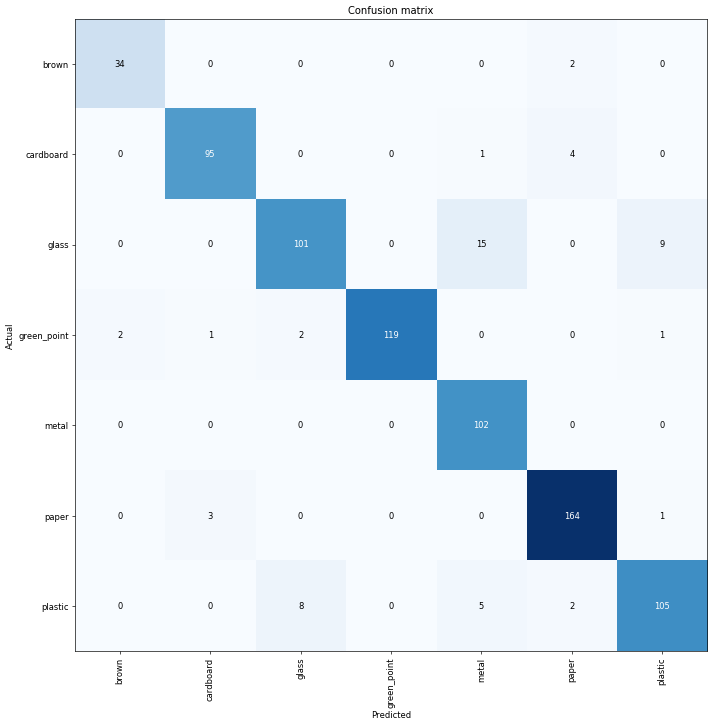

In [0]:
doc(interp.plot_top_losses)
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [0]:
interp.most_confused(min_val=2)


[('glass', 'metal', 15),
 ('glass', 'plastic', 9),
 ('plastic', 'glass', 8),
 ('plastic', 'metal', 5),
 ('cardboard', 'paper', 4),
 ('paper', 'cardboard', 3),
 ('brown', 'paper', 2),
 ('green_point', 'brown', 2),
 ('green_point', 'glass', 2),
 ('plastic', 'paper', 2)]

# Make new predictions on test data

In [0]:
preds = learn.get_preds(ds_type=DatasetType.Test)


In [39]:
print(preds[0].shape)
preds[0]

torch.Size([761, 7])


tensor([[6.6504e-07, 9.9995e-01, 5.6206e-06,  ..., 3.6729e-06, 3.4224e-05,
         2.8785e-06],
        [4.6047e-05, 2.2805e-03, 1.8568e-05,  ..., 5.6876e-06, 9.7764e-01,
         9.9717e-06],
        [9.0186e-03, 5.3937e-01, 1.6868e-03,  ..., 3.4442e-01, 5.6005e-03,
         9.9875e-02],
        ...,
        [5.3350e-03, 4.1767e-06, 8.4734e-08,  ..., 3.4416e-05, 6.4105e-06,
         3.0515e-07],
        [7.9659e-05, 6.6050e-05, 1.0918e-06,  ..., 2.5556e-06, 5.1265e-04,
         2.7625e-04],
        [2.6720e-04, 1.5266e-06, 6.4882e-07,  ..., 1.0446e-06, 2.4695e-07,
         1.5491e-08]])

In [0]:
data.classes


['brown', 'cardboard', 'glass', 'green_point', 'metal', 'paper', 'plastic']

In [0]:
## saves the index (0 to 5) of most likely (max) predicted class for each image
max_idxs = np.asarray(np.argmax(preds[0],axis=1))

In [0]:
yhat = []
for max_idx in max_idxs:
    yhat.append(data.classes[max_idx])

In [0]:
yhat

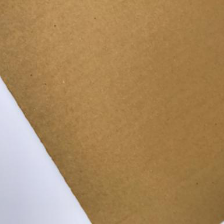

In [0]:
learn.data.test_ds[0][0]


In [0]:
y = []

## convert POSIX paths to string first
for label_path in data.test_ds.items:
    y.append(str(label_path)[37:])

In [0]:
## then extract waste type from file path
pattern = re.compile("([a-z_]+)[0-9]+")
for i in range(len(y)):
    y[i] = pattern.search(y[i]).group(1)

In [44]:
## predicted values
print(yhat[0:5])
## actual values
print(y[0:5])

['cardboard', 'paper', 'cardboard', 'green_point', 'plastic']
['cardboard', 'paper', 'cardboard', 'green_point', 'plastic']


# Test confusion matrix

In [48]:
cm = confusion_matrix(y,yhat)
print(cm)

[[ 30   0   1   1   2   3   0]
 [  0  97   0   0   0   4   0]
 [  0   1 106   0   9   0   9]
 [  0   1   0 124   0   0   0]
 [  0   1   6   1  93   0   2]
 [  0   1   2   1   1 142   2]
 [  0   0   4   0   2   0 115]]


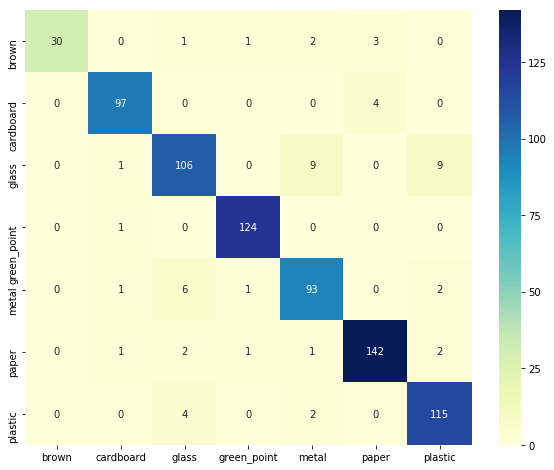

In [49]:
w= data.classes
df_cm = pd.DataFrame(cm,w,w)

plt.figure(figsize=(10,8))
sns.heatmap(df_cm,annot=True,fmt="d",cmap="YlGnBu")

In [0]:
correct = 0

for r in range(len(cm)):
    for c in range(len(cm)):
        if (r==c):
            correct += cm[r,c]


In [51]:
accuracy = correct/sum(sum(cm))
accuracy

0.9290407358738502

# Put model in production

In [0]:
learn.export()

In [0]:
defaults.device = torch.device('cpu')

In [0]:
learn = load_learner(path)

In [0]:
path.ls()

[PosixPath('/content/gdrive/My Drive/Mamuthackv2/data/test'),
 PosixPath('/content/gdrive/My Drive/Mamuthackv2/data/train'),
 PosixPath('/content/gdrive/My Drive/Mamuthackv2/data/valid'),
 PosixPath('/content/gdrive/My Drive/Mamuthackv2/data/.DS_Store'),
 PosixPath('/content/gdrive/My Drive/Mamuthackv2/data/models'),
 PosixPath('/content/gdrive/My Drive/Mamuthackv2/data/export.pkl')]

In [0]:
img = open_image(path/'botella.jpeg')

In [0]:
pred_class,pred_idx,outputs = learn.predict(img)
pred_class

Category cardboard